In [1]:
# Author: Nivin Jose Kovukunnel

In [2]:
# Importing the packages required.

import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from os import listdir
from os.path import isfile, join
import pygame
from math import sqrt


pygame 2.0.1 (SDL 2.0.14, Python 3.7.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# Parsing input
class ObjLoader(object):
    def __init__(self, fileName):
        self.vertices = []
        self.faces = []
        ##
        try:
            f = open(fileName)
            for line in f:
                if line[:2] == "v ":
                    index1 = line.find(" ") + 1
                    index2 = line.find(" ", index1 + 1)
                    index3 = line.find(" ", index2 + 1)

                    vertex = (float(line[index1:index2]), float(line[index2:index3]), float(line[index3:-1]))
                    vertex = (round(vertex[0], 2), round(vertex[1], 2), round(vertex[2], 2))
                    self.vertices.append(vertex)

                elif line[0] == "f":
                    string = line.replace("//", "/")
                    ##
                    i = string.find(" ") + 1
                    face = []
                    for item in range(string.count(" ")):
                        if string.find(" ", i) == -1:
                            face.append(string[i:-1])
                            break
                        face.append(string[i:string.find(" ", i)])
                        i = string.find(" ", i) + 1
                    ##
                    self.faces.append(tuple(face))

            f.close()
        except IOError:
            print(".obj file not found.")

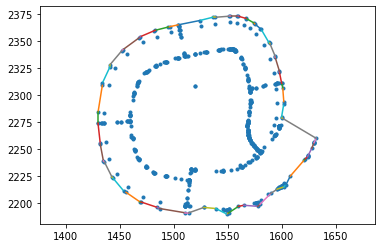

Boundary points:  [(1549.0, 2190.0), (1551.0, 2191.0), (1560.0, 2197.0), (1565.0, 2198.0), (1578.0, 2197.0), (1580.0, 2199.0), (1590.0, 2209.0), (1596.0, 2213.0), (1602.0, 2215.0), (1604.0, 2217.0), (1608.0, 2225.0), (1621.0, 2240.0), (1622.0, 2241.0), (1624.0, 2243.0), (1628.0, 2251.0), (1630.0, 2256.0), (1632.0, 2260.0), (1600.0, 2279.0), (1600.0, 2280.0), (1602.0, 2292.0), (1602.0, 2294.0), (1601.0, 2307.0), (1600.0, 2311.0), (1598.0, 2321.0), (1598.0, 2322.0), (1594.0, 2335.0), (1594.0, 2336.0), (1589.0, 2348.0), (1588.0, 2349.0), (1581.0, 2361.0), (1575.0, 2366.0), (1574.0, 2367.0), (1567.0, 2371.0), (1560.0, 2373.0), (1559.0, 2373.0), (1552.0, 2373.0), (1551.0, 2373.0), (1538.0, 2372.0), (1536.0, 2372.0), (1524.0, 2369.0), (1504.0, 2365.0), (1495.0, 2363.0), (1483.0, 2360.0), (1469.0, 2354.0), (1468.0, 2353.0), (1453.0, 2342.0), (1452.0, 2341.0), (1441.0, 2328.0), (1441.0, 2326.0), (1434.0, 2311.0), (1434.0, 2309.0), (1430.0, 2284.0), (1430.0, 2274.0), (1432.0, 2256.0), (1432.0, 

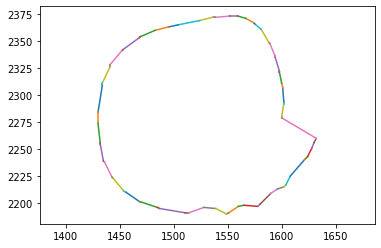

In [4]:
"""
Author: Fulin Kuang
Function: Concave hull calculation (Part B)
The code is based on Weizhen Fang's Part A group's implementation of 3D to 2D
The code directly continue development on their code and uses their result (a set of 2D coordinates) as input
The idea of this implementation is based on "Ball Pivoting"
1. Find out the boundary points that can be reached by the actual path, and the nearest point where the boundary points are out of the boundary
2. Connect the theoretical boundary points obtained by interpolation into a suitable polygon
The ball pivoting method was used to achieve concave, you can set the radius of this ball to achieve different output, if the radius is big enough, it can also used to calculate the convex hull
Regarding to the radius, please play around number "20" in the line 184, see 'p_r = concavehull(p, 20)'
Weizhen Fang's Part A group's implementation of 3D to 2D's results has been examined
A: We first used open3D's Qhull function to calculate the convex hull of the original obj file (based on 3D)
B: We then used our implementation to calculate the convex hull using Weizhen Fang's Part A group's result (based on 2D)
We then compared A and B, the result shows exactly the same, which proves the correctness of both part A and part B..
"""


def get_leftbottompoint(p):
    k = 0
    for i in range(1, len(p)):
        if p[i][1] <= p[k][1]:
            k = i
    return k

def multiply(p1, p2, p0):
    return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])


# Obtain the polar angle, which is obtained by seeking the arc tangent, considering the case of pi/2
def get_arc(p1, p0, the):
    # Compatible with sort_points_tan considerations
    if (p1[0] - p0[0]) == 0:
        if ((p1[1] - p0[1])) == 0:
            return -1;
        else:
            return math.pi / 2
    tan = float(p1[1] - p0[1]) / float(p1[0] - p0[0])
    arc = math.atan(tan) - the
    if arc >= 0:
        return arc
    else:
        return math.pi + arc


# Sort the polar angles, the sort result list does not contain the reference point
def sort_points_tan(p, pk, the):
    p2 = []
    for i in range(0, len(p)):
        p2.append({"index": i, "arc": get_arc(p[i], pk, the)})
    # print('Before sorting:',p2)
    p2.sort(key=lambda k: (k.get('arc')))
    # print('After sorting:',p2)
    p_out = []
    for i in range(0, len(p2)):
        p_out.append(p[p2[i]["index"]])
    return p_out


def distance(p1, p2):
    """
    Calculates the distance between two points.
    ```
    :param p1, p2: points
    :return: distance between points
    """
    p1x, p1y = p1
    p2x, p2y = p2
    return math.sqrt((p1x - p2x) ** 2 + (p1y - p2y) ** 2)


# r is the radius of the ball pivoting method
def concavehull(p, r):
    k = get_leftbottompoint(p)
    # print('Remove all points of the reference point before sorting:',p,'Reference point:',pk)
    pk = copy.deepcopy(p[k])
    p_result = [0, p[k]]
    the = 0
    # Point coordinates sorted by the angle between the connection line with the reference point and the positive x-axis
    # print('The other points are sorted by the angle between the reference point:',p_sort)
    while (True):
        thelist = []
        p_sort = sort_points_tan(p, pk, the)
        for i in range(len(p_sort)):
            thelist.append(math.atan2(p_sort[i][1] - pk[1], p_sort[i][0] - pk[0]))
            leng = distance(p_sort[i], pk)
            if (leng < 2 * r and leng != 0 and (p_sort[i] != p_result[-2]) or len(p_result) < 2):
                mid = [0.5 * (pk[0] + p_sort[i][0]), 0.5 * (pk[1] + p_sort[i][1])]
                arc2 = thelist[i] + math.pi * 0.5
                dist = math.sqrt(r ** 2 - 0.25 * (leng ** 2))
                C1 = [mid[0] + math.cos(arc2) * dist, mid[1] + math.sin(arc2) * dist]
                C2 = [mid[0] - math.cos(arc2) * dist, mid[1] - math.sin(arc2) * dist]
                t1 = True
                t2 = True
                for j in range(len(p_sort)):
                    if (distance(p_sort[j], C1) <= r and (p_sort[j] != pk and p_sort[j] != p_sort[i])):
                        t1 = False
                    if (distance(p_sort[j], C2) <= r and (p_sort[j] != pk and p_sort[j] != p_sort[i])):
                        t2 = False
                if (t1 or t2):
                    the = thelist[i]
                    pk = copy.deepcopy(p_sort[i])
                    p_result.append(p_sort[i])
                    break
        if (pk == p_result[1]):
            break
    p_result.remove(0)
    return p_result

# Plotting the output
def plotre(p, p_result):
    plt.figure()
    plt.axis('equal')
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], '.')
    # x, y = zip(*p_result)
    # plt.plot(x, y)
    for i in range(len(p_result) - 1):
        item_1 = p_result[i]
        item_2 = p_result[i + 1]
        # Abscissa, ordinate
        one_, oneI = item_1
        two_, twoI = item_2
        plt.plot([one_, two_], [oneI, twoI])

    plt.show()

def get_2D_points(Path):
    data = ObjLoader(Path)
    '''
        Program below is about finding projected 2D points along z axis
    '''
    # projection matrix along z axis
    projection_matrix = np.matrix([
        [1, 0, 0],
        [0, 1, 0],
    ])

    WIDTH, HEIGHT = 2000, 2000
    pygame.display.set_caption("3D projection!")
    pygame.display.set_mode((WIDTH, HEIGHT))

    scale = 1
    circle_pos = [WIDTH / 2, HEIGHT / 2]  # x, y

    # variable to contain all 2D projected points
    points = []
    # convert tuple point to matrix
    for Dim3 in data.vertices:
        Dim3 = np.matrix(np.asarray(Dim3))
        points.append(Dim3)

    single_points2D = []
    # for loop to find all 2d projected points
    for point in points:
        projected2d = np.dot(projection_matrix, point.reshape((3, 1)))

        x = int(projected2d[0][0] * scale) + circle_pos[0]
        y = int(projected2d[1][0] * scale) + circle_pos[1]
        single_points2D.append((x, y))
    return single_points2D

folder = 'C:/Users/nivin/Downloads/HULL-2-master/HULL-2-master/TestData/Model/410'
points2D = []
for f in listdir(folder):
    file_path = join(folder, f)
    if isfile(file_path):
        single_points2D = get_2D_points(file_path)
        for sin in single_points2D:
            points2D.append(sin)
p = points2D
p_r = concavehull(p, 20) #play around this number, higher number will lead to convex hull
plotre(p, p_r)

print("Boundary points: ", p_r)
plt.figure()
plt.axis('equal')
# x, y = zip(*p_r)
# plt.plot(x, y, "r")
for i in range(len(p_r) - 1):
    item_1 = p_r[i]
    item_2 = p_r[i + 1]
    # Abscissa, ordinate
    one_, oneI = item_1
    two_, twoI = item_2
    plt.plot([one_, two_], [oneI, twoI])
plt.show()

In [5]:
# Ramer–Douglas–Peucker algorithm

def calculate_distance(point_1, point_2):
    return  sqrt((point_1[0] - point_2[0]) ** 2 + (point_1[1] - point_2[1]) ** 2)


def point_line_distance(point, start, end):
    if (start == end):
        return calculate_distance(point, start)
    else:
        n = abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
        d = sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        return n / d


def Ramer_Douglas_Peucker_Algorithm(points, epsilon):
       
    distance_max = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > distance_max:
            index = i
            distance_max = d

    if distance_max >= epsilon:
        output = Ramer_Douglas_Peucker_Algorithm(points[:index+1], epsilon)[:-1] + Ramer_Douglas_Peucker_Algorithm(points[index:], epsilon)
        
    else:
        output = [points[0], points[-1]]

    return output

In [6]:
def Plotting_Results(points, results,epsilon):
    """
    draw
    :param points: All points set
    :param results: All edge sets
    :return: picture
    """
    # defining figure size
    width = 10
    height = 10
    plt.figure(figsize=(width,height))
    
    all_x = []
    all_y = []
    
    for item in points:
        a, b = item
        all_x.append(a)
        all_y.append(b)

    for i in range(len(results) - 1):
        item_1 = results[i]
        item_2 = results[i + 1]
        # Abscissa, ordinate
        one_, oneI = item_1
        two_, twoI = item_2
        
        
        plt.plot([one_, two_], [oneI, twoI])
        plt.title("Douglas Pecker Algorithm: {} Vertices removed from the shape, epsilon: {} ".format(len(p_r)-len(results),epsilon))
    
    
    plt.scatter(all_x, all_y)
    plt.show()

The amount of vertices reduced using sigma value 0.001 is 66. This means that 4 points are removed


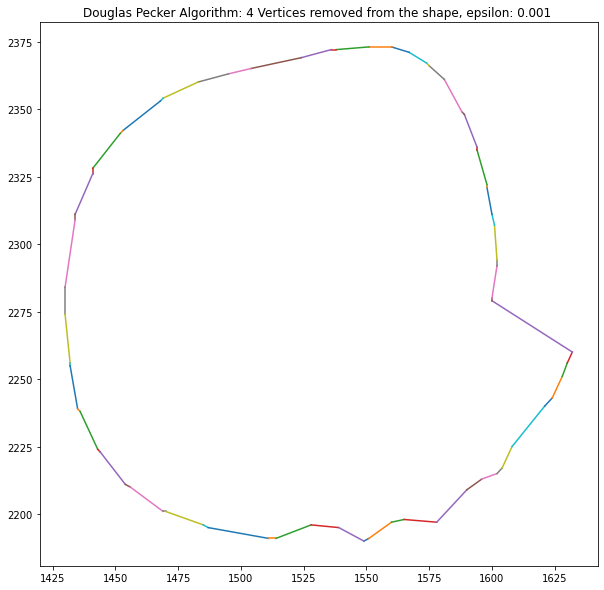

The amount of vertices reduced using sigma value 0.01 is 66. This means that 4 points are removed


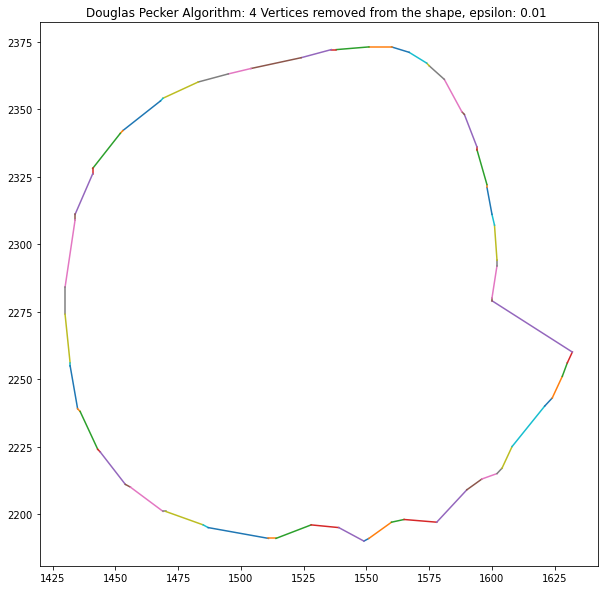

The amount of vertices reduced using sigma value 0.1 is 66. This means that 4 points are removed


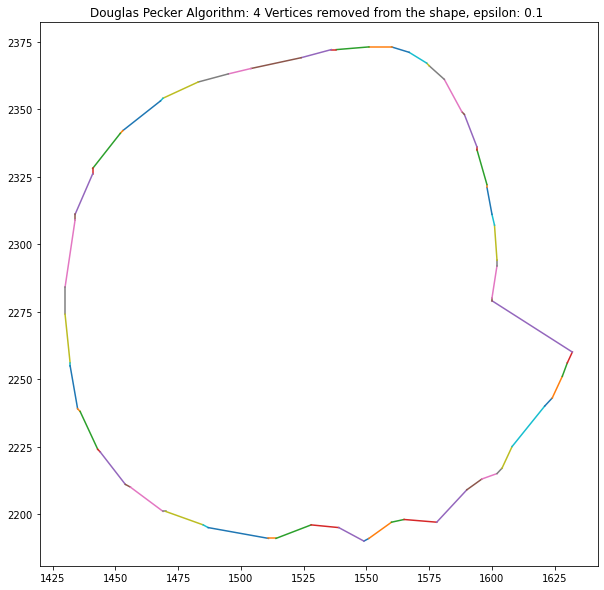

The amount of vertices reduced using sigma value 0.5 is 40. This means that 30 points are removed


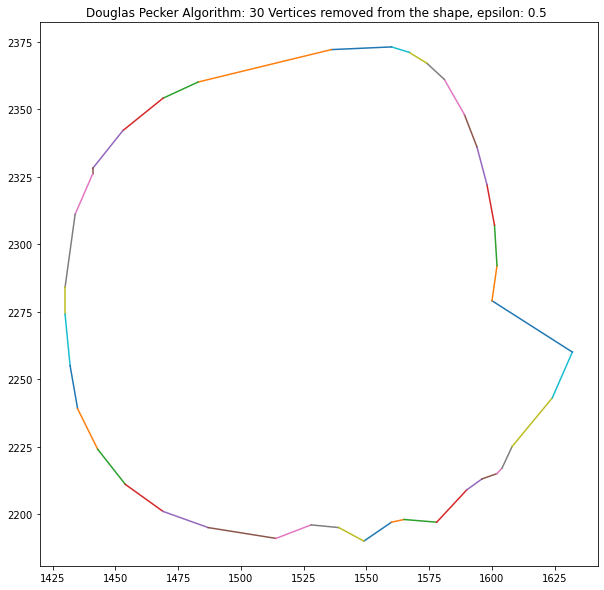

The amount of vertices reduced using sigma value 1 is 34. This means that 36 points are removed


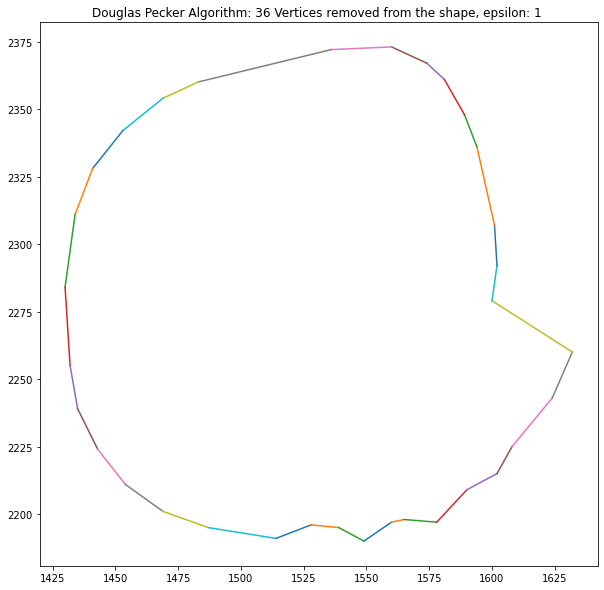

The amount of vertices reduced using sigma value 10 is 11. This means that 59 points are removed


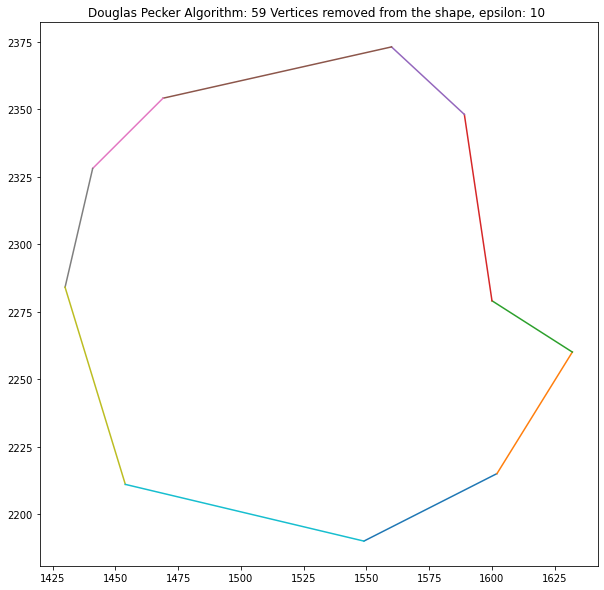

In [7]:
epsilon = [0.001,0.01,0.1,0.5,1,10]

for eps in epsilon:
    vertex_reduced = Ramer_Douglas_Peucker_Algorithm(p_r,eps)
    print("The amount of vertices reduced using sigma value {} is {}. This means that {} points are removed".format(eps,len(vertex_reduced), len(p_r)-len(vertex_reduced)))
    Plotting_Results([],vertex_reduced,eps)